Test elastic problems using MFEANet

* Multi-phase elastic analysis
* Heterogeneous material system

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from functools import reduce

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from feanet.iterator import PsiNet
from feanet.iterator import PsiIterator
from data.dataset import MechanicalDataSet

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
bs = 1 # batch size
k = 0 # test data index
mode = 'plane_stress' # plane strain or plane stress
n_test = 2**5
no_neumann = False
ku, kf = 2, 2
nb_layers = 3
model_name = 'dirich_33x33_smoother'
model_dir = 'model/learn_iterator/thermal'

test_set = MechanicalDataSet('data/data_elasticity/multiphase.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
elem_mask_test, node_mask_test, dirich_idx_test, dirich_value_test, neumann_idx_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))
solution_test, rhs_test, d_test, d_idx_test, t_idx_test, t_test, t_conn_test, m_test, emsk_test, nmsk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(elem_mask_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(node_mask_test[k], 0).to(device_predict))

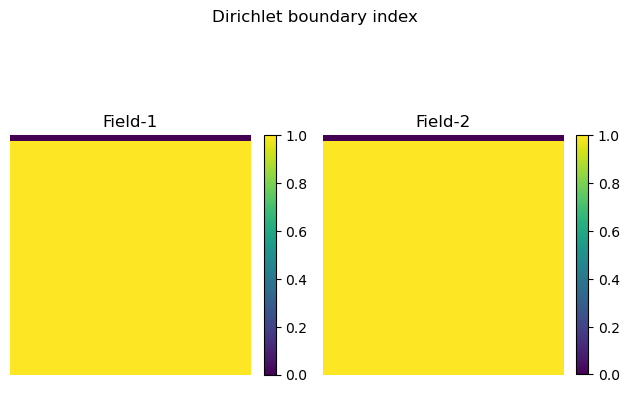

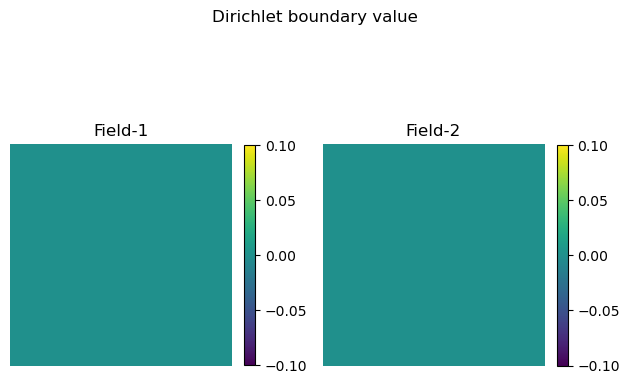

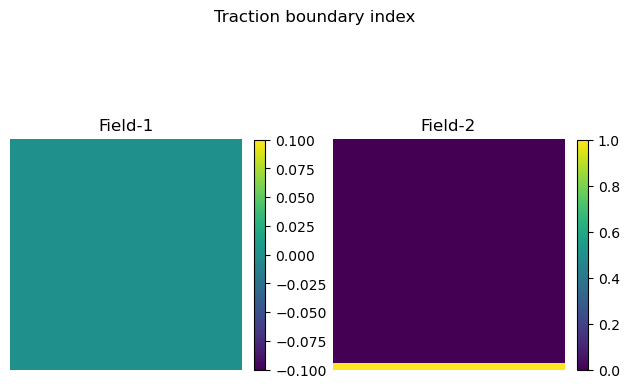

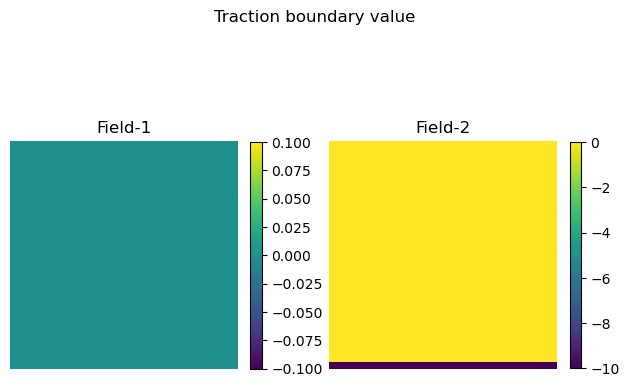

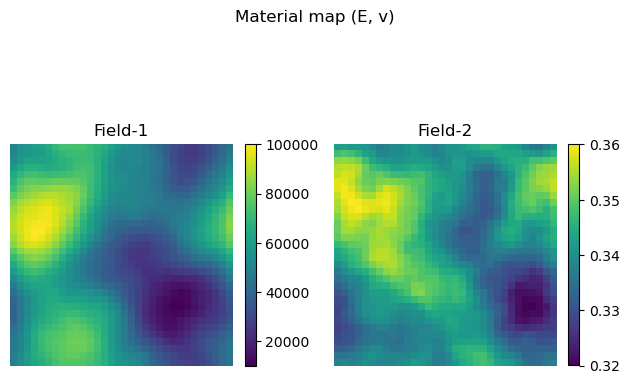

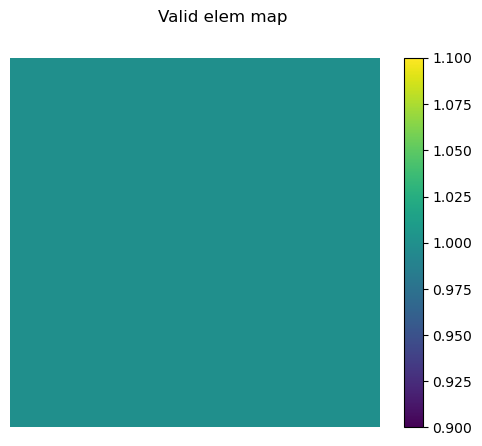

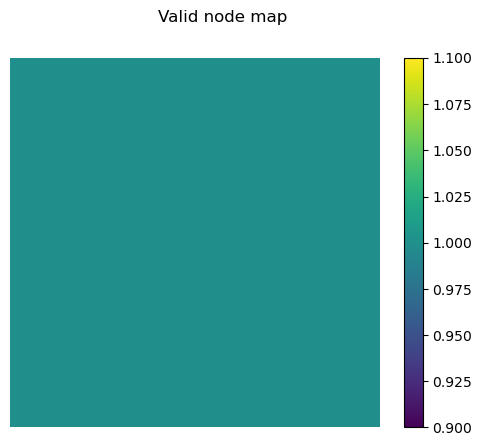

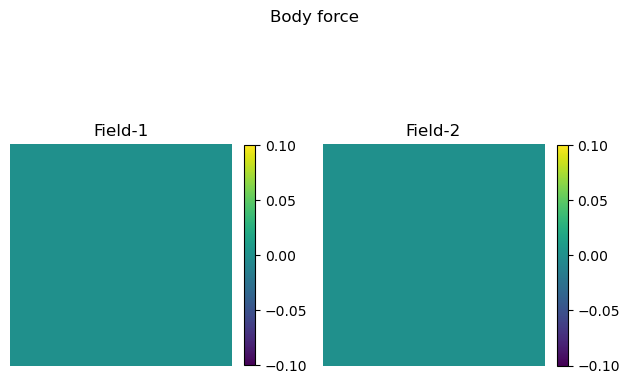

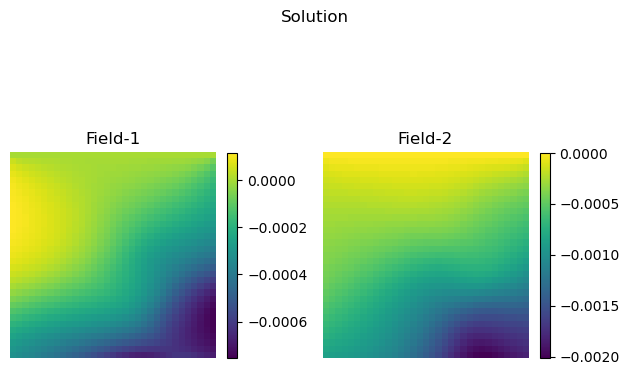

In [4]:
plot.plot_elasticfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(neumann_idx_test[k], ftitle='Traction boundary index')
plot.plot_elasticfield(neumann_value_test[k], ftitle='Traction boundary value')
plot.plot_elasticfield(material_test[k], ftitle='Material map (E, v)')
plot.plot_thermalfield(elem_mask_test[k], ftitle='Valid elem map')
plot.plot_thermalfield(node_mask_test[k], ftitle='Valid node map')
plot.plot_elasticfield(f_test[k], ftitle='Body force')
plot.plot_elasticfield(u_test[k], ftitle='Solution')

In [5]:
n_elem = n_test
ku, kf = 2, 2
h = 0.2

grid = SingleGrid(h, n_elem, mode, device_predict, no_neumann)

0 11.230812704846558
1 8.90498451342945
2 6.536069021461844
3 6.340534197960057
4 5.8197462124357004
5 5.634559316834884
6 5.40425432897132
7 5.254810810575597
8 5.110223560871206
9 4.99403444737125
10 4.888125913773631
11 4.796035665782525
12 4.712510330060187
13 4.637382799150161
14 4.568688513345655
15 4.505775355520365
16 4.447686669253248
17 4.393859180119236
18 4.343725830690998
19 4.296866746007977
20 4.252904418134348
21 4.211531697696936
22 4.172480342021819
23 4.135522814660921
24 4.100460733190118
25 4.067122148519253
26 4.035356172627015
27 4.005030229568379
28 3.976027026153385
29 3.9482424604367816
30 3.92158369670802
31 3.895967662183971
32 3.871319739609551
33 3.8475726910306243
34 3.8246657344956376
35 3.802543764629037
36 3.7811566832112633
37 3.7604588258358267
38 3.740408466654951
39 3.7209673899109488
40 3.702100517296771
41 3.683775582964866
42 3.665962848980452
43 3.6486348554386407
44 3.631766200304064
45 3.615333344878627
46 3.5993144414176457
47 3.583689179963

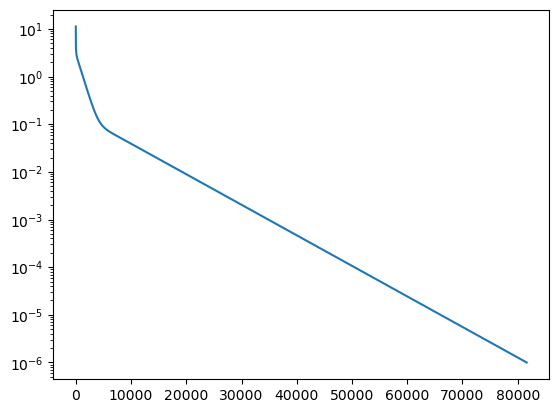

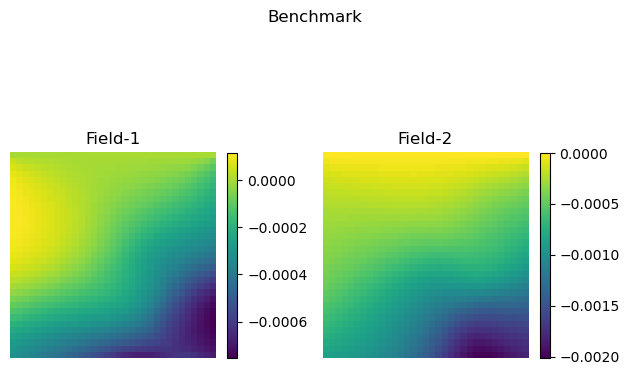

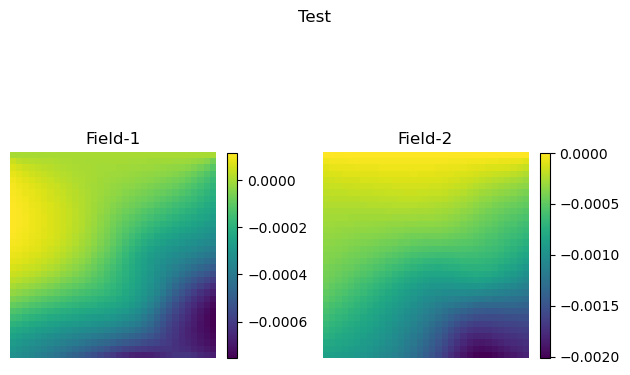

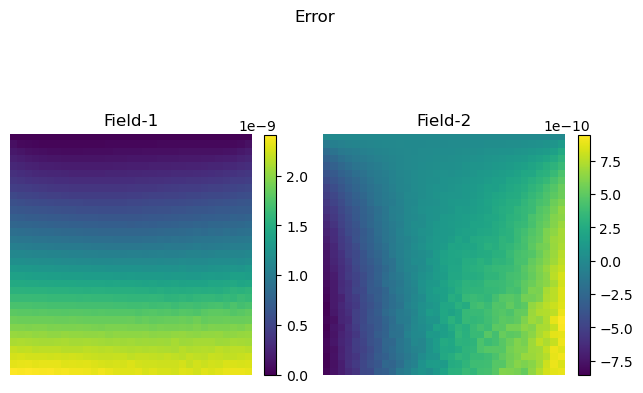

In [6]:
EPS = 1e-6
n_jac = 0
jacu_test = EPS*torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, h, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if (True):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, nmsk_test, d_test, d_idx_test, None, None, h, rhs_test, t_test, t_conn_test)
        residual = grid.net(None, None, h, jacu_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")

    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_elasticfield(jacu_test[0], "Benchmark")
    plot.plot_elasticfield(solution_test[0], "Test")
    plot.plot_elasticfield(jacu_test[0]-solution_test[0], 'Error')

In [7]:
# import the learned model and loss train
no_neumann_test = False # considering Neumann bc for testing
my_net = PsiNet(nb_layers=nb_layers, mode='elastic').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, h, n_elem, no_neumann_test, psi_net=my_net, grid=grid, nb_layers=nb_layers, batch_size=1, iterator='psi')
my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

RuntimeError: Error(s) in loading state_dict for PsiNet:
	size mismatch for smoother.0.weight: copying a param with shape torch.Size([1, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([2, 2, 3, 3]).
	size mismatch for smoother.1.weight: copying a param with shape torch.Size([1, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([2, 2, 3, 3]).
	size mismatch for smoother.2.weight: copying a param with shape torch.Size([1, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([2, 2, 3, 3]).

In [ ]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual_H = new_iterator.grid.net(None, None, h, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual_H).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS):
        u_test = new_iterator.PsiRelax(u_test, m_test, nmsk_test, d_test, d_idx_test, None, None, hsize, rhs_test, t_test, t_conn_test, 1)
        residual_H = new_iterator.grid.net(None, None, h, u_test, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual_H).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='H-Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.ylabel('|r|')
plt.xlabel('# of iterations')
plt.yscale('log')
plt.legend()
plt.savefig('results/jac_res.jpg', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
with torch.no_grad():
    n = n_test
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, pacnet=None, device=device, nb_layers=3, mode=mode, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(f_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = EPS*torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')
    
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()


TypeError: MultiGrid.__init__() missing 1 required positional argument: 'no_neumann'

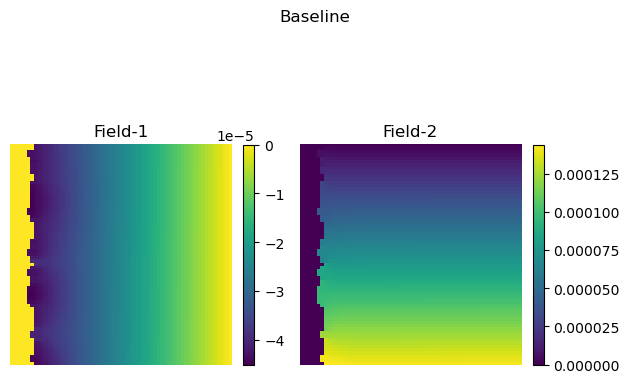

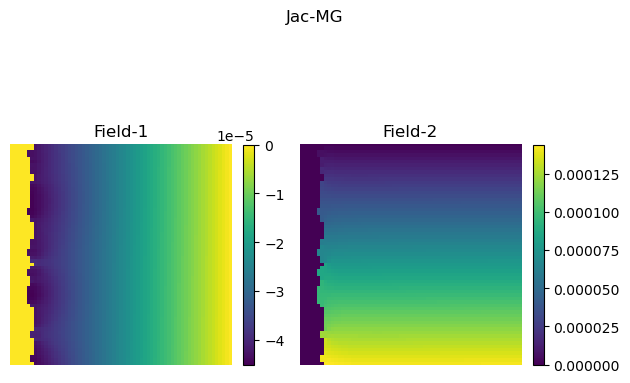

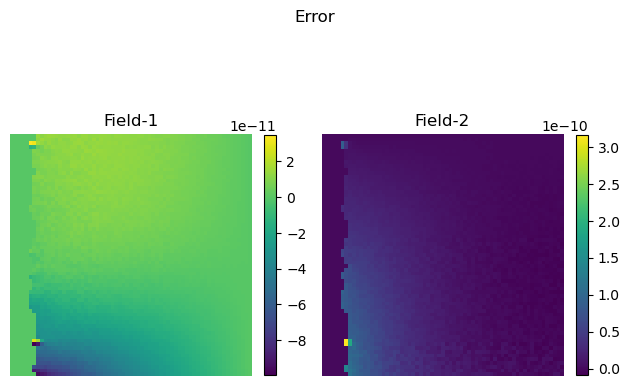

In [ ]:
plot.plot_elasticfield(solution_test[k], ftitle='Baseline')
plot.plot_elasticfield(u_mg_jac[k], ftitle='Jac-MG')
plot.plot_elasticfield(solution_test[k]-u_mg_jac[k], ftitle='Error')

In [ ]:
from feanet.post_processing import ElasticPostProcessing
ePost = ElasticPostProcessing(h, 'plane_stress', m_test.float(), emsk_test.float(), nmsk_test.float())
ePost.ComputeStrain(u_mg_jac.float())
ePost.ComputeStress(u_mg_jac.float())
energy = ePost.ComputeStrainEnergyDensity()

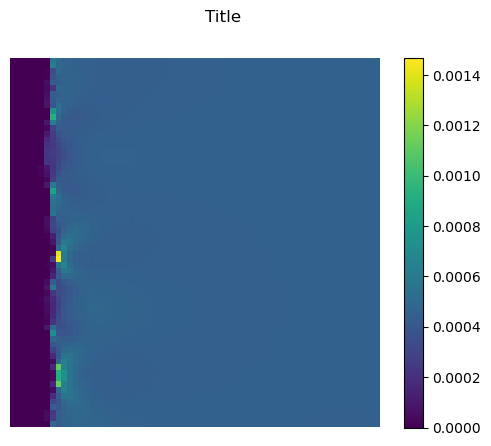

In [ ]:
plot.plot_thermalfield(energy[0])

Test two-phase material system

In [ ]:
bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=False)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=1
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [ ]:
plot.plot_elasticfield(d_idx_test[0], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(d_test[0], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(t_idx_test[0], ftitle='Traction boundary index')
plot.plot_elasticfield(t_test[0], ftitle='Traction boundary value')
plot.plot_elasticfield(m_test[0], ftitle='Material map (E, v)')
plot.plot_elasticfield(f_test[0], ftitle='Body force')
plot.plot_elasticfield(solution_test[0], ftitle='Solution')

In [ ]:
with torch.no_grad():
    n = n_test
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, nb_layers=nb_layers, mode='elastic', iterator='jac') # create a multigrid model
    u_mg_jac = torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_jac,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_jac = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


In [ ]:
with torch.no_grad():
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, nb_layers=nb_layers, mode='elastic', iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_psi = mg_jac.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


In [ ]:
plt.plot(res_arr_mgjac, label='MG-$\Psi_J$')
plt.plot(res_arr_mgpsi, label='MG-$\Psi_H$')
plt.yscale('log')
plt.xlabel('# iterations')
plt.ylabel('|r|')
plt.legend(prop={'size':18})
plt.show()

In [ ]:
plot.plot_elasticfield(solution_test[0], 'True solution', 'U1', 'U2')

In [ ]:
plot.plot_elasticfield(u_mg_psi[0], 'Psi solution', 'U1', 'U2')

In [ ]:
res_jac = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
plot.plot_elasticfield(torch.abs(res_jac[0]), 'Residual of Jacobi-Multigrid')

In [ ]:
res_psi = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
plot.plot_elasticfield(torch.abs(res_psi[0]), 'Residual of Psi-Multigrid', 'R1', 'R2')

In [ ]:
res_jac_flat = torch.flatten(res_jac*d_idx_test).cpu().detach().numpy()
res_psi_flat = torch.flatten(res_psi*d_idx_test).cpu().detach().numpy()

plt.hist(res_jac_flat, bins=30, label='Jacobi-Multigrid')
plt.hist(res_psi_flat, bins=30, label='Psi-Multigrid')

plt.xlabel('r')
plt.legend()
plt.ylabel('frequency')